In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
from statsmodels.graphics.api import qqplot
import os
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection

In [3]:
dir_path = "C:\\Users\\weber\\Documents\\Project-1018"
# dir_path =  "C:\\Users\\chen5\\ProbTimeSeries\\Project"

In [4]:
df = pd.read_csv(os.path.join(dir_path,'importdata','HOURLY_LOAD-202208.csv'))

In [5]:
df.columns = df.columns.str.replace(' ','')

In [6]:
data = df['CSWS'][:120]
# train, test = model_selection.train_test_split(csws, train_size=100)
train = data[:100]
test1 = data[100:110]
test2 = data[110:120]

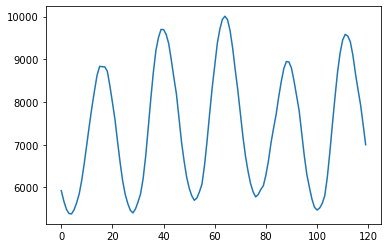

In [7]:
plt.plot(data)

In [8]:
arima = pm.auto_arima(train, stepwise=False,Seasonal = True)
arima

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

(10,)


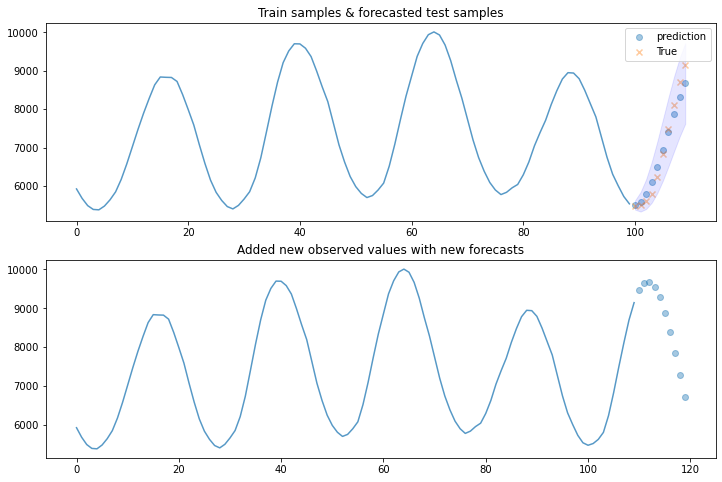

In [9]:
# Looks good
data = df['CSWS'][:120]
preds, conf_int = arima.predict(n_periods=test1.shape[0],
                                return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o',label = "prediction")
axes[0].scatter(x_axis[train.shape[0]:], test1, alpha=0.4, marker='x',label = "True")
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
axes[0].legend()

# fill the section where we "held out" samples in our model fit

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test1)
new_preds, new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 10)

# new_x_axis2 = np.arange(data.shape[0] + 20)
data = np.append(train,test1)
print(new_x_axis[data.shape[0]:data.shape[0]+10].shape)
axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:data.shape[0]+10], new_preds, alpha=0.4, marker='o')
# axes[1].scatter(new_x_axis[data.shape[0]:], test2, alpha=0.4, marker='x')
# axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
#                      new_conf_int[:, 0],
#                      new_conf_int[:, 1],
#                      alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()

In [10]:
df.columns

Index(['MarketHour', 'CSWS', 'EDE', 'GRDA', 'INDN', 'KACY', 'KCPL', 'LES',
       'MPS', 'NPPD', 'OKGE', 'OPPD', 'SECI', 'SPRM', 'SPS', 'WAUE', 'WFEC',
       'WR'],
      dtype='object')

In [80]:
# # Training on the entire dataset with update
# df = pd.read_csv(os.path.join(dir_path,'importdata','HOURLY_LOAD-202208.csv'))
# data = df[" CSWS"]
# step_size = 12
# for i in range(96,df[" CSWS"].shape[0],step_size):
#     train = data[:i]
#     arima = pm.auto_arima(train, stepwise=False)
#     print(arima)
    


In [64]:
step_sizes = [6,12,24,36,48,60,72,84,96,168]
# all_predss = np.array([])
# df1 = pd.DataFrame({"index":np.arange(data.shape[0]-96)})
for step_size in step_sizes:
    all_preds = np.array([])
    print(step_size)
    for idx in range(96,data.shape[0],step_size):
#         print(idx)
        preds, conf_int = arima.predict(n_periods=step_size,
                                        return_conf_int=True)
        test = data[idx:idx+step_size]

        all_preds = np.append(all_preds,preds)
        arima.update(test)
    print(data.shape[0]-96 - all_preds.shape[0])
    if step_size == 1 or data.shape[0]-96 - all_preds.shape[0] ==0:
        df1[f"WF ARIMA {step_size}"] = all_preds
        continue
    else:
        all_preds = all_preds[:data.shape[0]-96 - all_preds.shape[0]]
        df1[f"WF ARIMA {step_size}"] = all_preds

6
0
12
0
24
0
36
0
48
-24
60
-12
72
0
84
-24
96
-24
168
-24


In [65]:
df.shape

(744, 18)

In [66]:
data[100:112]

100    5469.647
101    5514.535
102    5620.743
103    5800.900
104    6232.328
105    6823.009
106    7480.070
107    8107.154
108    8694.651
109    9144.880
110    9450.578
111    9584.449
Name:  CSWS, dtype: float64

In [67]:
# pd.Series(data = df[f'WF ARIMA {step}'],index = np.arange(110,748))

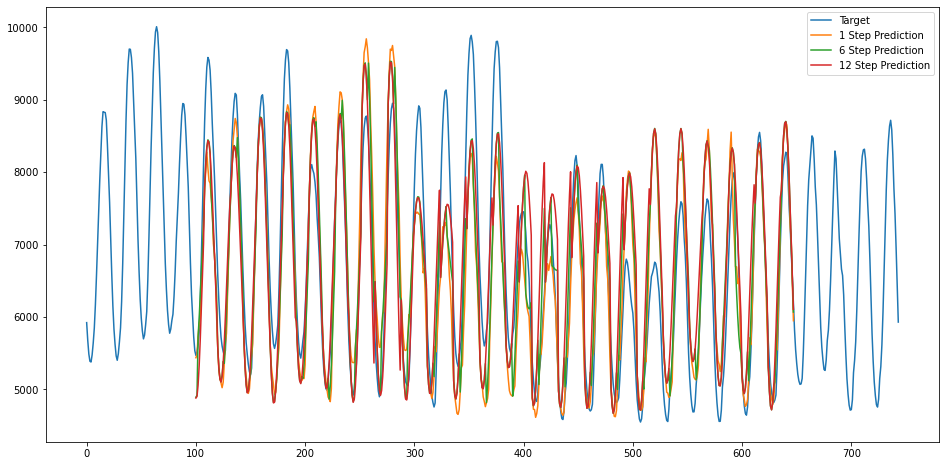

In [68]:
step_sizes = [1,6,12]
fig,ax = plt.subplots(1,1,figsize = (16,8))
plt.plot(data,label = "Target")
for step in step_sizes: 
    plt.plot(pd.Series(data = df1[f'WF ARIMA {step}'],index = np.arange(100,748)),label = f"{step} Step Prediction")
plt.legend()

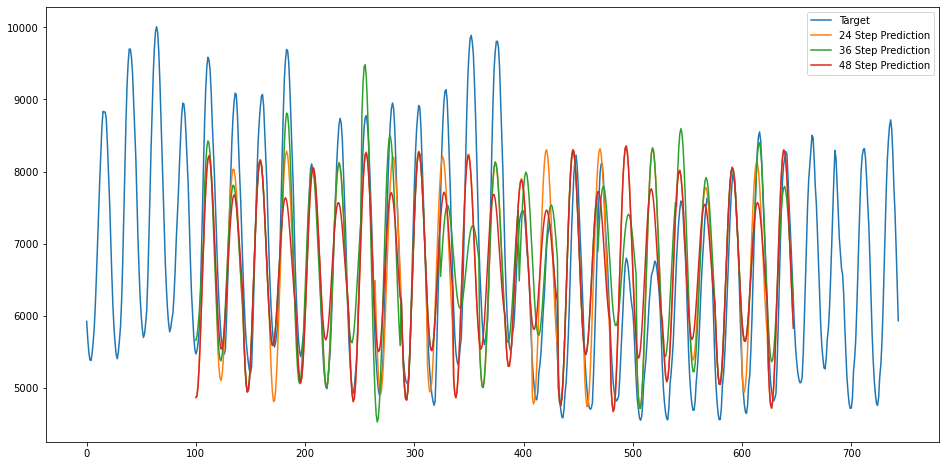

In [69]:
step_sizes = [24,36,48]
fig,ax = plt.subplots(1,1,figsize = (16,8))
plt.plot(data,label = "Target")
for step in step_sizes: 
    plt.plot(pd.Series(data = df1[f'WF ARIMA {step}'],index = np.arange(100,748)),label = f"{step} Step Prediction")
plt.legend()

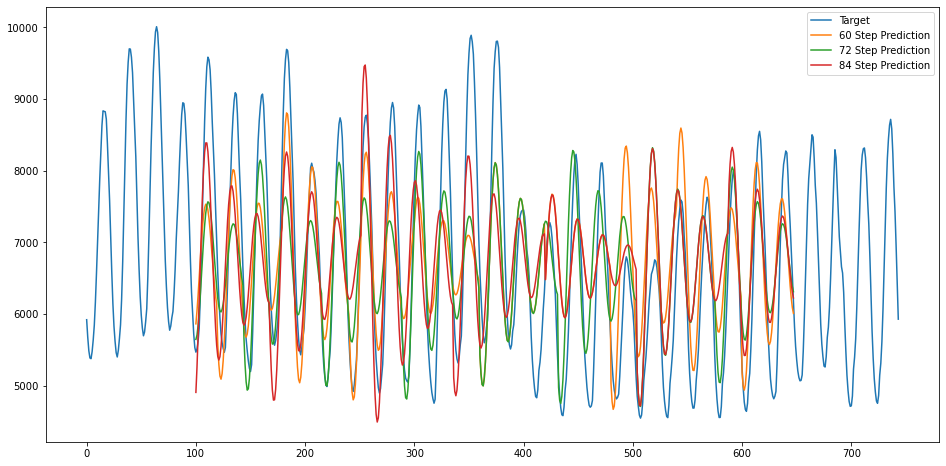

In [70]:
step_sizes = [60,72,84]
fig,ax = plt.subplots(1,1,figsize = (16,8))
plt.plot(data,label = "Target")
for step in step_sizes: 
    plt.plot(pd.Series(data = df1[f'WF ARIMA {step}'],index = np.arange(100,748)),label = f"{step} Step Prediction")
plt.legend()

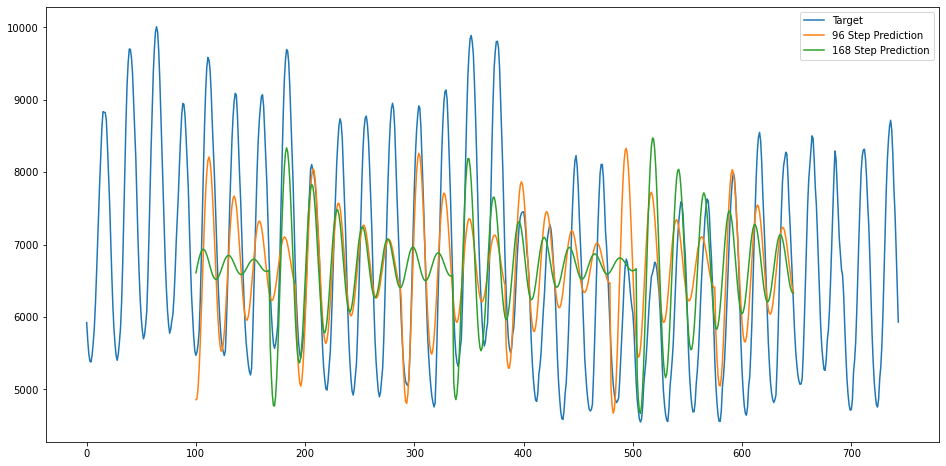

In [71]:
step_sizes = [96,168]
fig,ax = plt.subplots(1,1,figsize = (16,8))
plt.plot(data,label = "Target")
for step in step_sizes: 
    plt.plot(pd.Series(data = df1[f'WF ARIMA {step}'],index = np.arange(100,748)),label = f"{step} Step Prediction")
plt.legend()

In [75]:
df1[f'WF ARIMA {step}'].shape

(648,)

In [76]:
from sklearn.metrics import mean_squared_error
step_sizes = [1,6,12,24,36,48,60,72,84,96,168]
rmse = []
for step in step_sizes:
    rmse.append(mean_squared_error(data[96:748],df1[f'WF ARIMA {step}'],squared = False))
df2 = pd.DataFrame({"ARIMA Step Sizes":step_sizes,"RMSE Score":rmse})
df2

,ARIMA Step Sizes,RMSE Score
0,1,94.399077
1,6,363.321844
2,12,660.278410
3,24,731.038560
4,36,787.899061
5,48,831.374676
6,60,883.656115
7,72,934.512624
8,84,963.483017
9,96,1030.086858


Text(0, 0.5, 'RMSE Score')

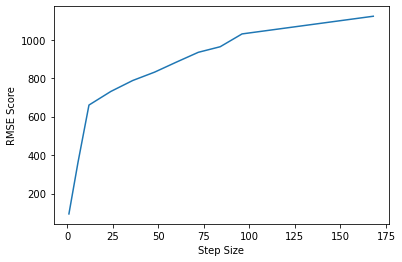

In [77]:
plt.plot(df2["ARIMA Step Sizes"],df2["RMSE Score"])
plt.xlabel("Step Size")
plt.ylabel("RMSE Score")

### GP

In [109]:
# from sklearn import gaussian_process
# from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel,ExpSineSquared

In [ ]:
# kernel = ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 1e5)) + RBF(length_scale=2) 

In [ ]:
# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))